In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 

In [27]:
rot_matrices = np.load('../../../data/rot_matrices/rot_matrices28.npy')
rot_matrices[100:102]

array([[[ 9.99879554e-01, -1.48349476e-03,  1.54491833e-02],
        [ 1.48659661e-03,  9.99998877e-01, -1.89295402e-04],
        [-1.54488852e-02,  2.12239306e-04,  9.99880636e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])

In [83]:
def rotationMatrixToEulerAngles(R):
    # Check for gimbal lock
    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])


vo_yaw_changes2 = [np.rad2deg(np.rad2deg(rotationMatrixToEulerAngles(mat)[2])) for mat in rot_matrices]
# apparently I have to multiply with (180/pi)^2 so my angles are in the right scale

In [84]:
vo_yaw_changes2[170:180]

[6.104651376747209,
 -1.329581156989531,
 0.8384444715201255,
 5.647143154757355,
 6.825755790218598,
 -2.4703019331333427,
 4.479199036233055,
 0.6722588772159789,
 -6.019381380075825,
 5.773544134634177]

In [30]:
def normalize_angle(angle):
    angle = angle % 360
    if angle > 180:
        angle -= 360
    elif angle < -180:
        angle += 360
    return angle

In [31]:
def extract_roll_from_matrix(rotation_matrix):
    if not np.all(rotation_matrix== 0):
        rot = Rotation.from_matrix(rotation_matrix)
        euler = rot.as_euler('zyx', degrees=True)
        roll_change_deg = euler[2] 
        return roll_change_deg
    return 0.0

vo_roll_changes = [extract_roll_from_matrix(mat) for mat in rot_matrices]
vo_roll_changes[40:50]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [32]:
sum(vo_roll_changes)

0.3669402239167895

In [33]:
def extract_roll_forward_from_matrix(rotation_matrix):
    if not np.all(rotation_matrix== 0):
        rot = Rotation.from_matrix(rotation_matrix)
        euler = rot.as_euler('xyz', degrees=True)
        roll_forward_change_deg = euler[1] 
        return roll_forward_change_deg
    return 0.0

vo_roll_forward_changes = [extract_roll_from_matrix(mat) for mat in rot_matrices]
sum(vo_roll_forward_changes)

0.3669402239167895

In [34]:
def extract_yaw_from_matrix(rotation_matrix):
    if not np.all(rotation_matrix== 0):
        rot = Rotation.from_matrix(rotation_matrix)
        euler = rot.as_euler('zyx')
        yaw_change_deg = euler[0] 
        return yaw_change_deg*((180/np.pi)**2)
    return 0.0

vo_yaw_changes = [extract_yaw_from_matrix(mat) for mat in rot_matrices]
vo_yaw_changes[170:180]

[6.116708897609387,
 -1.2777376185031302,
 0.882444998857326,
 5.609010676433325,
 6.832600414583312,
 -2.5122450542245263,
 4.472231915793084,
 0.6981599292825169,
 -6.012899135308961,
 5.774348025654152]

absolute angle change: 81.61643714783987


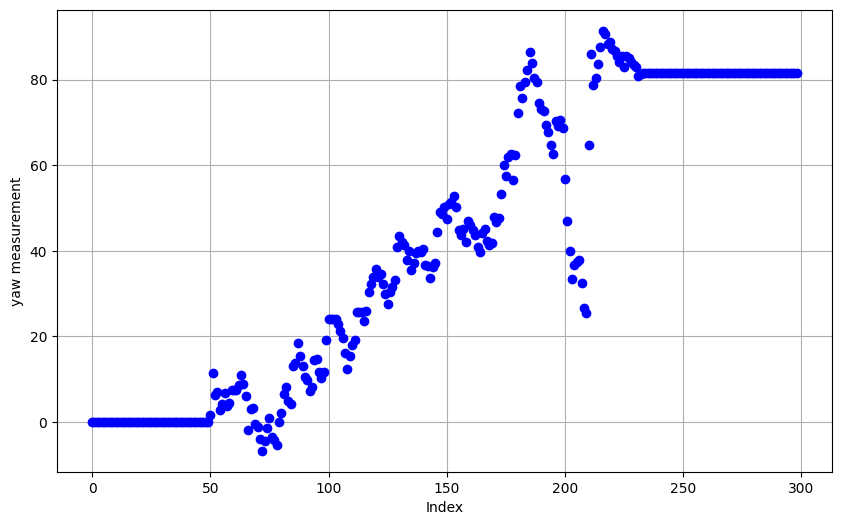

In [51]:
curr_yaw = 0
vo_yaws = []
for yaw_change in vo_yaw_changes:
    curr_yaw += yaw_change
    vo_yaws.append(normalize_angle(curr_yaw))

print(f"absolute angle change: {normalize_angle(vo_yaws[-1]-vo_yaws[0] )}")


plt.figure(figsize=(10, 6))
plt.plot(range(len(vo_yaws)), vo_yaws, marker='o', linestyle='none', color ='b')
plt.xlabel('Index')
plt.ylabel('yaw measurement')
plt.grid(True)
plt.show()

# Imu data

In [58]:
imu_list = []
imu_path = '../../../data/recordings/series28/imu_data.txt'
with open(imu_path, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        t = float(parts[0])
        delta_pos_part = float(parts[1])  
        yaw = float(parts[2])
        imu_list.append([delta_pos_part, yaw])

imu_yaw_arr = np.array(imu_list)[1:,1]
imu_yaw_arr[:5]


array([120.64228842, 120.74532136, 120.8256504 , 120.8647909 ,
       120.74182748])

starts at 120 so let's subtract that.

In [59]:
start = imu_yaw_arr[0]
imu_yaw_arr = np.array([normalize_angle(yaw-start ) for yaw in imu_yaw_arr])

In [60]:
print(f"imu_yaw_arr.shape = {imu_yaw_arr.shape}")
print(f"rot_matrices.shape = {rot_matrices.shape}")

imu_yaw_arr.shape = (299,)
rot_matrices.shape = (299, 3, 3)


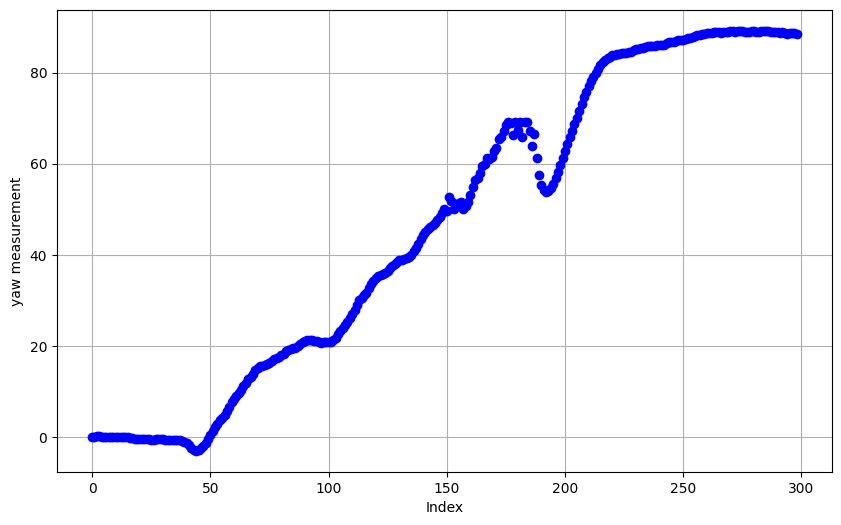

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(imu_yaw_arr)), imu_yaw_arr, marker='o', linestyle='none', color ='b')
plt.xlabel('Index')
plt.ylabel('yaw measurement')
plt.grid(True)
plt.show()

In [39]:
print(f"absolute angle change: {normalize_angle(imu_yaw_arr[-1]-imu_yaw_arr[0] )}")

absolute angle change: 88.54707191530326


# Fusing

In [40]:
def yaw_to_rotation_matrix(yaw_degrees):
    yaw_radians = np.deg2rad(yaw_degrees)
    rotation_matrix = np.array([
        [np.cos(yaw_radians), -np.sin(yaw_radians), 0],
        [np.sin(yaw_radians), np.cos(yaw_radians), 0],
        [0, 0, 1]
    ])
    return rotation_matrix



In [41]:
def fuse_yaw(yaw_vo, yaw_imu, weight_imu):
    diff = normalize_angle(yaw_imu - yaw_vo)
    fused_yaw = normalize_angle(yaw_vo + weight_imu * diff)
    return fused_yaw

In [42]:
def fuse_rotation_matrices(vo_matrices, imu_yaws, weight_imu=0.2):
    fused_yaws = []
    old_yaw = imu_yaws[0] # init
    for i in range(len(vo_matrices)):
        yaw_vo = extract_yaw_from_matrix(vo_matrices[i])
        yaw_imu = imu_yaws[i]

        yaw_vo_new = old_yaw + yaw_vo
        yaw_vo_new = normalize_angle(yaw_vo_new)
        fused_yaw = fuse_yaw(yaw_vo_new, yaw_imu, weight_imu)
        
        old_yaw = fused_yaw
        fused_yaws.append(fused_yaw)
    
    return fused_yaws

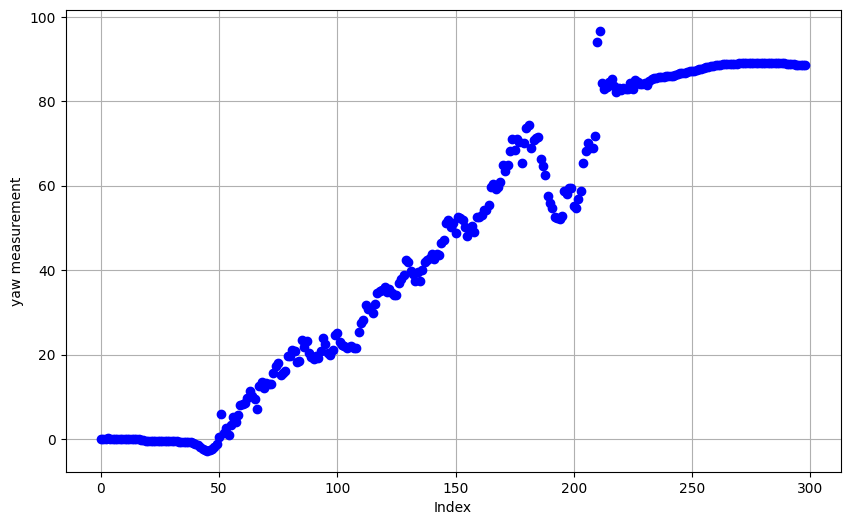

In [63]:
fused_yaws = fuse_rotation_matrices(rot_matrices, imu_yaw_arr, weight_imu=0.5)
fused_yaws = [normalize_angle(yaw-fused_yaws[0]) for yaw in fused_yaws]
plt.figure(figsize=(10, 6))
plt.plot(range(len(fused_yaws)), fused_yaws, marker='o', linestyle='none', color ='b')
plt.xlabel('Index')
plt.ylabel('yaw measurement')
plt.grid(True)
plt.show()

# ABC


In [67]:
class YawFusionComplementary():
    def __init__(self, weight_imu):
        self.old_yaw = 0.0
        self.weight_imu = weight_imu

    def set_offset(self, offset):
        self.offset = offset
    
    def step_deg(self, yaw_imu, rot_mat_vo):

        rot = Rotation.from_matrix(rot_mat_vo)
        euler_angles = rot.as_euler('zyx')
        euler_angles *= (180/np.pi)**2

        yaw_change_vo = euler_angles[0]
        new_yaw_vo = self.old_yaw + yaw_change_vo
        new_yaw_vo = normalize_angle(new_yaw_vo)

        yaw_imu = normalize_angle(yaw_imu - self.offset)
        diff = normalize_angle(yaw_imu - new_yaw_vo)
        fused_yaw_deg = normalize_angle(new_yaw_vo + self.weight_imu * diff)

        self.old_yaw = fused_yaw_deg
        
        return fused_yaw_deg

In [80]:
yaw_filter = YawFusionComplementary(0.5)
yaw_filter.set_offset(imu_yaw_arr[0])

degs_filtered = []
for img_id in range(299):
    degs_filtered.append(yaw_filter.step_deg(imu_yaw_arr[max(0,img_id )], rot_matrices[img_id]))

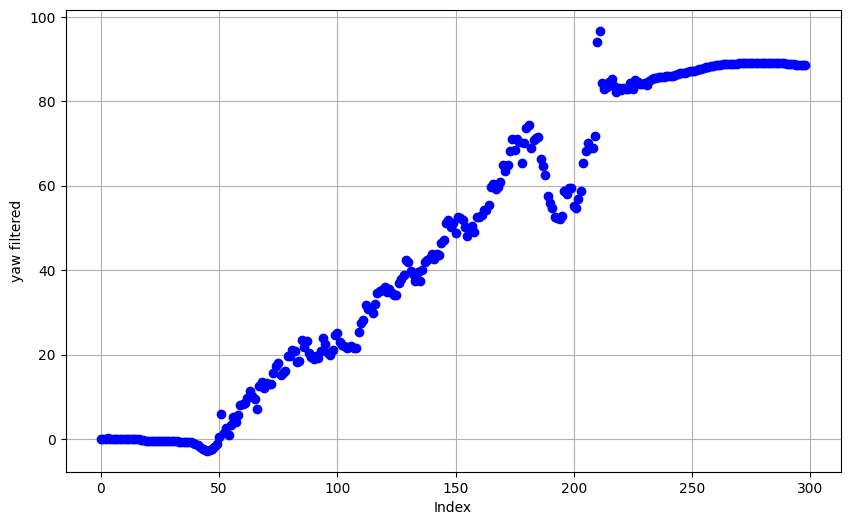

In [82]:
fused_yaws = degs_filtered

plt.figure(figsize=(10, 6))
plt.plot(range(len(fused_yaws)), fused_yaws, marker='o', linestyle='none', color ='b')
plt.xlabel('Index')
plt.ylabel('yaw filtered')
plt.grid(True)
plt.show()

# Evaluation

The Yaw estimate from the Visual Odometry is pretty noisy and probably worse than the one from the IMU. 
Typically one fuses gyro and accelerometer for heading representation with the complementary filter. And then the gyro is used for small bursts and the accelerometer is used to correct the gyro drift with only 0.02 weight. However in this use case I had to put the weight of the non-drift estimate up because the yaw changes measured by the Visual Odometry were too noisy.

From this perspective is also worth trying the VIO script with 1.0 as the parameter for IMU weight. This would ignore all the rotation data from the visual odometry and only use IMU data paired with the translation vectors of VO.